In [1]:
########################################################################### START ###########################################################################
# Access to Drive
# Modules
# Data import
# DataFrames

## Gives access to the Drive
from google.colab import drive
drive.mount('/content/drive')

## Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys, os
from pathlib import Path
import shutil
import glob
import itertools

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('/content/drive/MyDrive/Leukopy')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

## GPU status verification
tf.test.gpu_device_name()

## GPU type verification
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Thu Aug  5 12:04:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |    347MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

In [ ]:
########################################################################### DATAFRAME

## Need to copy all the files on the local computer
!cp -r "/content/drive/MyDrive/Leukopy/data/main_dataset.zip" .
!unzip main_dataset.zip

## Create the original dataframes 
path = Path('/content/main_dataset/')

df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

In [3]:
def choose_classes(df_train, df_test, df_valid, n_classes = 12):

  # Option à 11 classes, sans les BL
  if n_classes == 11:
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

  # Option à 8 classes (IG, SNE), sans les BL :
  if n_classes == 8:
    df_train = df_train[df_train["label"] != "BL"]
    df_test = df_test[df_test["label"] != "BL"]
    df_valid = df_valid[df_valid["label"] != "BL"]

    df_train["label"] = df_train["label_2"]
    df_test["label"] = df_test["label_2"]
    df_valid["label"] = df_valid["label_2"]

  # Option à 9 classes (IG, SNE, BL)
  if n_classes == 9:
    df_train["label"] = df_train["label_2"]
    df_test["label"] = df_test["label_2"]
    df_valid["label"] = df_valid["label_2"]

  return n_classes, df_train, df_test, df_valid

n_classes, df_train, df_test, df_valid = choose_classes(df_train, df_test, df_valid, n_classes = 11)

In [4]:
df_train["label"].value_counts()

EO     2352
PLT    1743
SNE    1263
BNE    1212
ERB    1162
MO     1068
LY      946
BA      903
MY      833
MMY     734
PMY     461
Name: label, dtype: int64

In [5]:
########################################################################### Génération d'images ###########################################################################

batch_size = 32
img_height  = 360
img_width = 360

train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True,
                                                   preprocessing_function = preprocess_input)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True,
                                                     preprocessing_function = preprocess_input)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False, 
                                                 preprocessing_function = preprocess_input)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


In [6]:
########################################################################### Grad-CAM Functions

import matplotlib.cm as cm
def get_img_array(img_path, size = (img_height, img_width)):

  img = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  array = tf.keras.preprocessing.image.img_to_array(img)
  array = np.expand_dims(array, axis = 0)
  return array

def make_heatmap(img_array, model, last_conv_layer, class_index):

  grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
 
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  for i in range(512):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)
  return heatmap

def gradcam(model, img_path, class_index = None, alpha = 0.5, plot = True):

  # Détecte la dernière couche de convolution (pas terrible : il faudrait sélectionner sur le type, pas sur le nom) :
  for layer in reversed(model.layers):
    if 'conv' in layer.name:
      last_conv_layer = model.get_layer(layer.name)
      break

  # Chargement + mise en forme de l'image :
  img_array = get_img_array(img_path, size = (img_height, img_width))

  # Choix de la classe à représenter :
  if class_index == None :
    # Désactiver Sotfmax sur la couche de sortie :
    model.layers[-1].activation = None
    # Prédiction + classe la plus probable :
    predict = model.predict(img_array)
    class_index = np.argmax(predict[0])

  # Calcul de la CAM : resize pour comparaison avec l'image finale
  heatmap = make_heatmap(img_array, model, last_conv_layer, class_index)
  big_heatmap = heatmap
  #big_heatmap = cv2.resize(heatmap, dsize = (img_height, img_width), interpolation = cv2.INTER_CUBIC)

  ## Traitement de la Heatmap
  # 1/ Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()
  # 2/ On passe dans ReLu, pour flinguer les valeurs négatives
  big_heatmap = np.maximum(0, big_heatmap)
  
  ## Superposition de l'image et de la Heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)

  # 3/ Jet colormap
  jet = cm.get_cmap("jet")

  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))
  return big_heatmap, superimposed_img

In [7]:
# Calcul des poids pour compenser le déséquilibre des classes

def compute_weights(method = 3):

  if method == 1:
    counter = Counter(training_set.classes)     
    class_weights = {class_id : float(max(counter.values()))/num_images for class_id, num_images in counter.items()} 
    return class_weights

  if method == 2:
    class_weights = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(training_set.classes),
                                         y = training_set.classes)
    class_weights = dict(enumerate(class_weights))
    return class_weights

  counter = Counter(training_set.classes)                          
  class_weights = {class_id : (1/num_images)*float(sum(counter.values()))/2 for class_id, num_images in counter.items()} 
  return class_weights

In [8]:
################################################### MODEL - FUNC. (Test 05/08/2021 - Inf. Mode) ####################################################
# VGG19 + Dense(1280, Relu) + Dropout(0.2) + Dense(640, Relu) + Dropout(0.2) + Dense(n_classes, Softmax) 
# weights = 'ImageNet'
# include_top = False

# Model (Functional API)
inputs = layers.Input(shape = (img_height,img_width,3))
base_model = VGG19(include_top = False,
                   weights = "imagenet",
                   input_tensor = inputs,
                   input_shape = (img_height,img_width,3),
                   pooling = 'avg')
base_model.training = False     # Nécessaire pour le fine-tuning ensuite : sans ça, le modèle est perdu...
base_output = base_model.output # Cette écriture permet d'avoir les couches de "base_model" au même niveau que les couches suivantes (voir model.summary())=> Grad-CAM peut fonctionner
x = layers.Dense(units = 1280, activation = 'relu', name = 'dense_1')(base_output)
x = layers.Dropout(rate = 0.2, name = 'dropout_1')(x)
x = layers.Dense(units = 640, activation = 'relu', name = 'dense_2')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_2')(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax', name = 'final_softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Freeze EfficientNet (doit être fait AVANT de compiler, sinon aucun effet)
base_model.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

80142336/80134624 [==============================] - 0s 0us/step


In [9]:
# Structure du modèle
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 360, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 360, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 180, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 180, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 180, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 90, 90, 128)       0     

In [9]:
## Training (05/08/2021) - VGG19 with Inf. Mode
# Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 2, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]
                    
## Compute weights :
class_weights = compute_weights(method = 3)

## Training :
epochs = 30
training_history = model.fit(x = training_set, 
                             epochs = epochs,
                             callbacks = callbacks_list,
                             validation_data = validation_set, 
                             class_weight = class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
397/397 [==============================] - 382s 912ms/step - loss: 8.1476 - accuracy: 0.5075 - val_loss: 1.1337 - val_accuracy: 0.5607
Epoch 2/30
397/397 [==============================] - 362s 912ms/step - loss: 5.1500 - accuracy: 0.6625 - val_loss: 0.7459 - val_accuracy: 0.7231
Epoch 3/30
397/397 [==============================] - 361s 909ms/step - loss: 4.4814 - accuracy: 0.7047 - val_loss: 0.6539 - val_accuracy: 0.7653
Epoch 4/30
397/397 [==============================] - 360s 907ms/step - loss: 4.1288 - accuracy: 0.7357 - val_loss: 0.6898 - val_accuracy: 0.7416
Epoch 5/30
397/397 [==============================] - 360s 905ms/step - loss: 4.0146 - accuracy: 0.7412 - val_loss: 0.6453 - val_accuracy: 0.7688
Epoch 6/30
397/397 [==============================] - 359s 903ms/step - loss: 3.9252 - accuracy: 0.7477 - val_loss: 0.6366 - val_acc

In [10]:
## Sauvegarde
model.save("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_trainfalse")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_trainfalse/assets


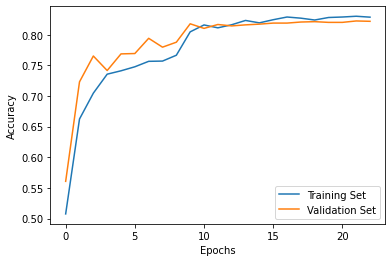

In [11]:
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(early_stopping.stopped_epoch), training_accuracy[0:early_stopping.stopped_epoch], label = 'Training Set')
plt.plot(np.arange(early_stopping.stopped_epoch), validation_accuracy[0:early_stopping.stopped_epoch], label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
## Évaluation sur les données de test :
model.evaluate(testing_set)

# Léger overfitting ou pas... telle est la question

80/80 [==============================] - 18s 227ms/step - loss: 0.4480 - accuracy: 0.8314


[0.44798436760902405, 0.8313679099082947]

In [ ]:
########################################################################### ANALYSE - MODEL(2) - FUNC. #########################################

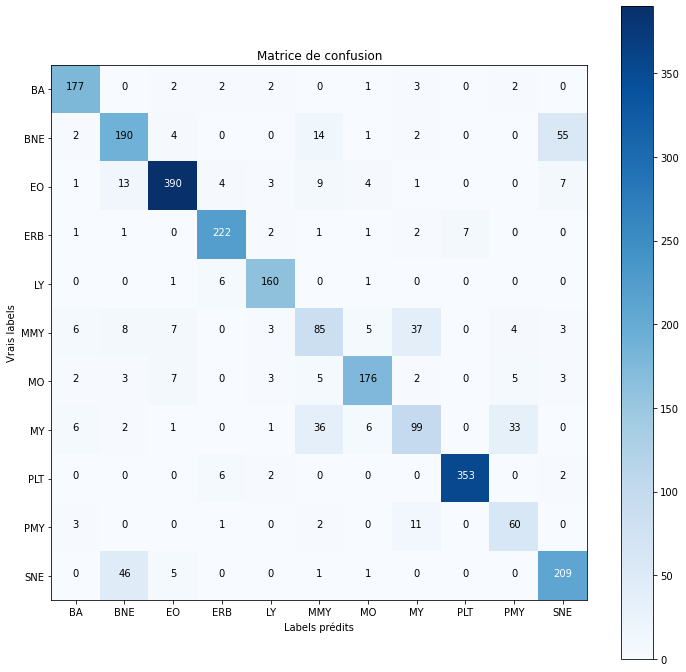

Classification Report : 


precision    recall  f1-score support
BA   0.893939  0.936508  0.914729     189
BNE  0.722433  0.708955  0.715631     268
EO   0.935252  0.902778  0.918728     432
ERB  0.921162  0.936709   0.92887     237
LY   0.909091  0.952381  0.930233     168
MMY  0.555556  0.537975  0.546624     158
MO   0.897959  0.854369  0.875622     206
MY   0.630573  0.538043  0.580645     184
PLT  0.980556  0.972452  0.976487     363
PMY  0.576923  0.779221  0.662983      77
SNE  0.749104   0.79771  0.772643     262

In [14]:
### 1 -- Matrice de confusion + rapport de classification ("présentable")

def print_classification_report(testing_set, labels):

  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred)
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report : avant Fine-Tuning")
  return display(df_report)

print_classification_report(testing_set, label_map)

# Ajouter fonction pour enregistrer df_report dans un .csv + transfert sur Drive

In [15]:
### 2 -- DataFrames pour l'exploitation
predictions = model.predict(testing_set)
y_pred = tf.argmax(predictions, axis = 1)

# DF avec le résultat et le label de toutes les images du test :
df_results = pd.DataFrame(data = {"real":testing_set.classes,
                                  "pred":y_pred, 
                                  "img_path":df_test["img_path"]})

# Tri des images : mal classé (df_false), bien classé (df_true):
df_false = df_results[df_results["real"] != df_results["pred"]].reset_index(drop = True)
df_true = df_results[df_results["real"] == df_results["pred"]].reset_index(drop = True)

# Ajouter fonction pour enregistrer les df_false et df_true dans un .csv + transfert sur Drive

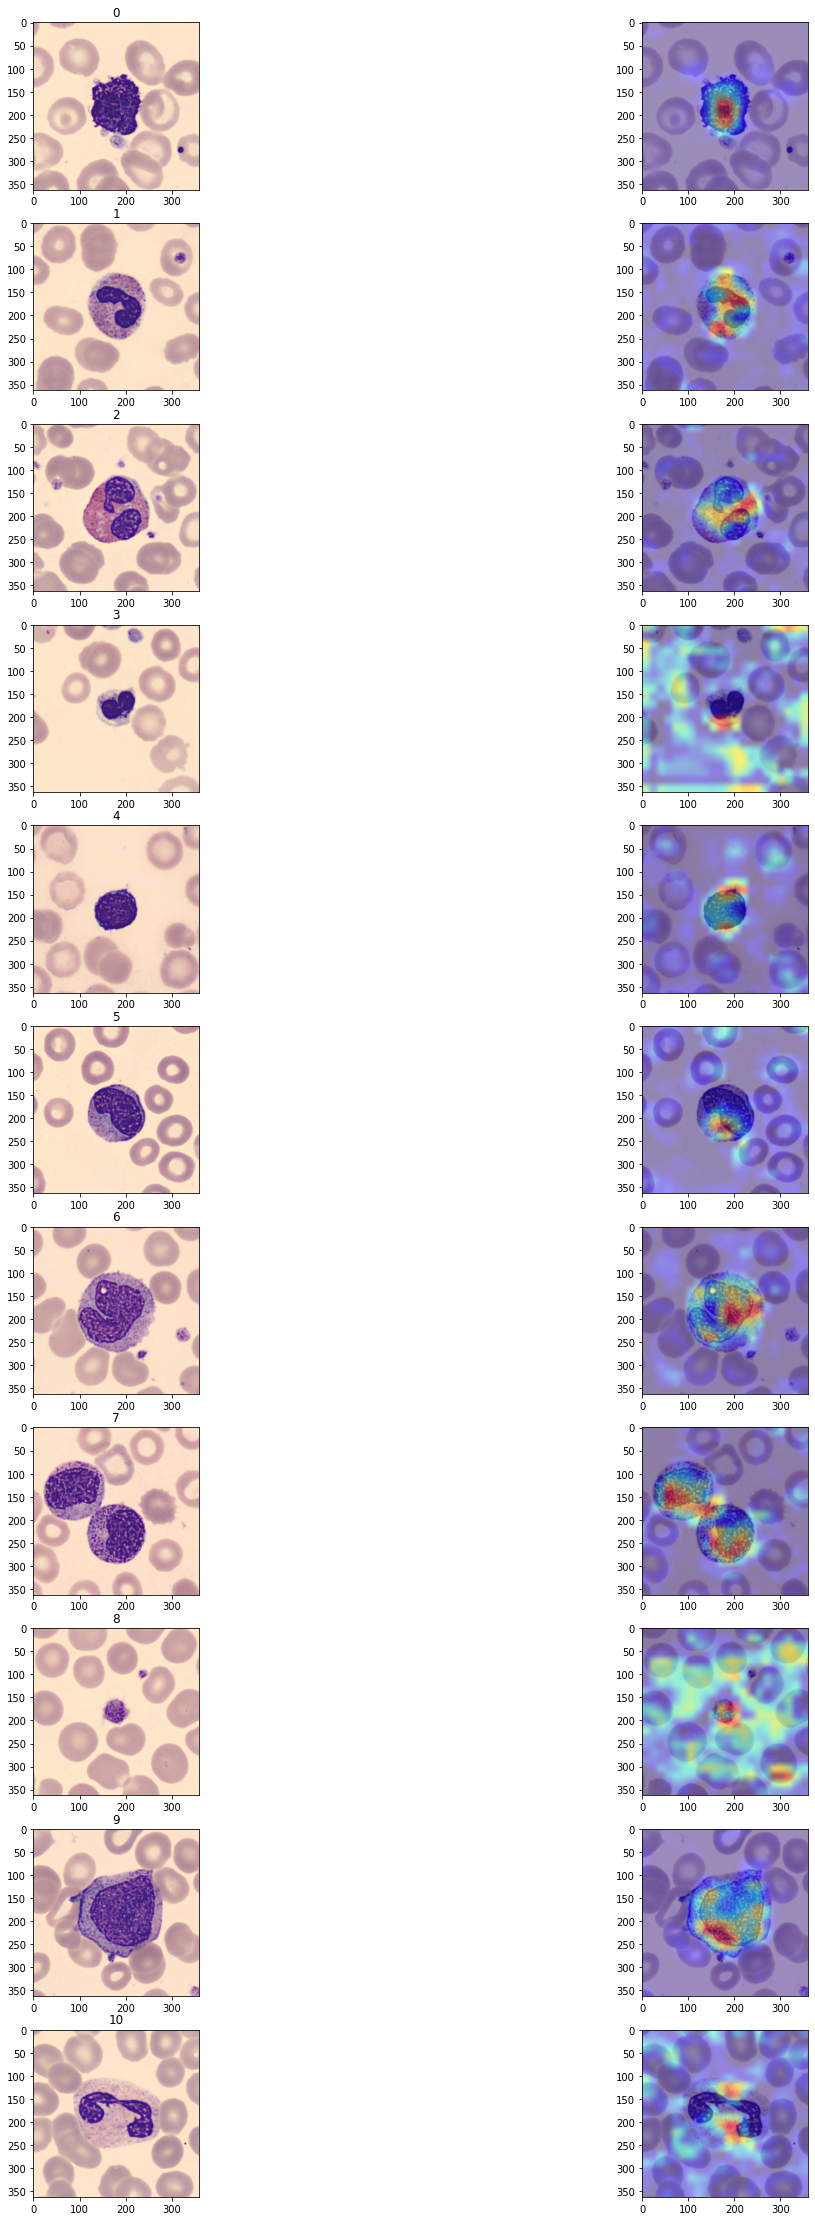

In [16]:
### 3 -- Grad-CAM sur les images bien classées :

fig = plt.figure(figsize = (20, 40))
i = 0

for cell_class in range(n_classes):
  df_temp = df_true[df_true["real"] == cell_class]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_true.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(n_classes,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(df_true.loc[id[0],"real"])

  fig.add_subplot(n_classes,2,i+2)
  plt.imshow(superimposed_img)

  i += 2

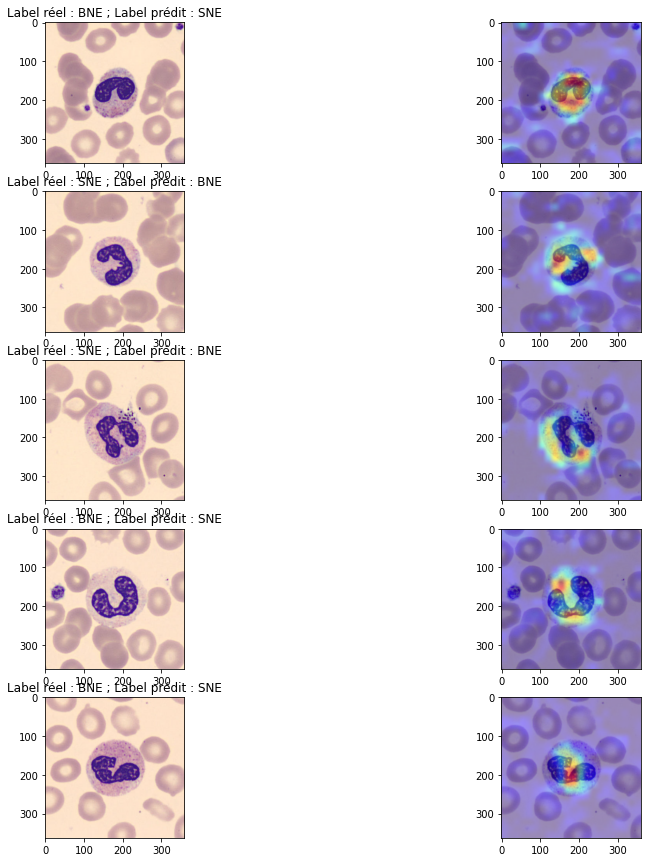

In [17]:
### 4 -- Exemples d'images mal classées :
# Exemple : Confusion BNE/SNE : labels 1 et 10

conf_bne_sne = df_false[((df_false["real"] == 1) & (df_false["pred"] == 10)) | ((df_false["real"] == 10) & (df_false["pred"] == 1))]

i = 0

fig = plt.figure(figsize = (15,15))

for id in np.random.choice(conf_bne_sne.index, size = 5, replace = False):
  img_path = conf_bne_sne.loc[id,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(5,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf_bne_sne.loc[id,"real"]],
                                                   list(label_map.keys())[conf_bne_sne.loc[id,"pred"]]))
  
  fig.add_subplot(5,2,i+2)
  plt.imshow(superimposed_img)
  i = i + 2

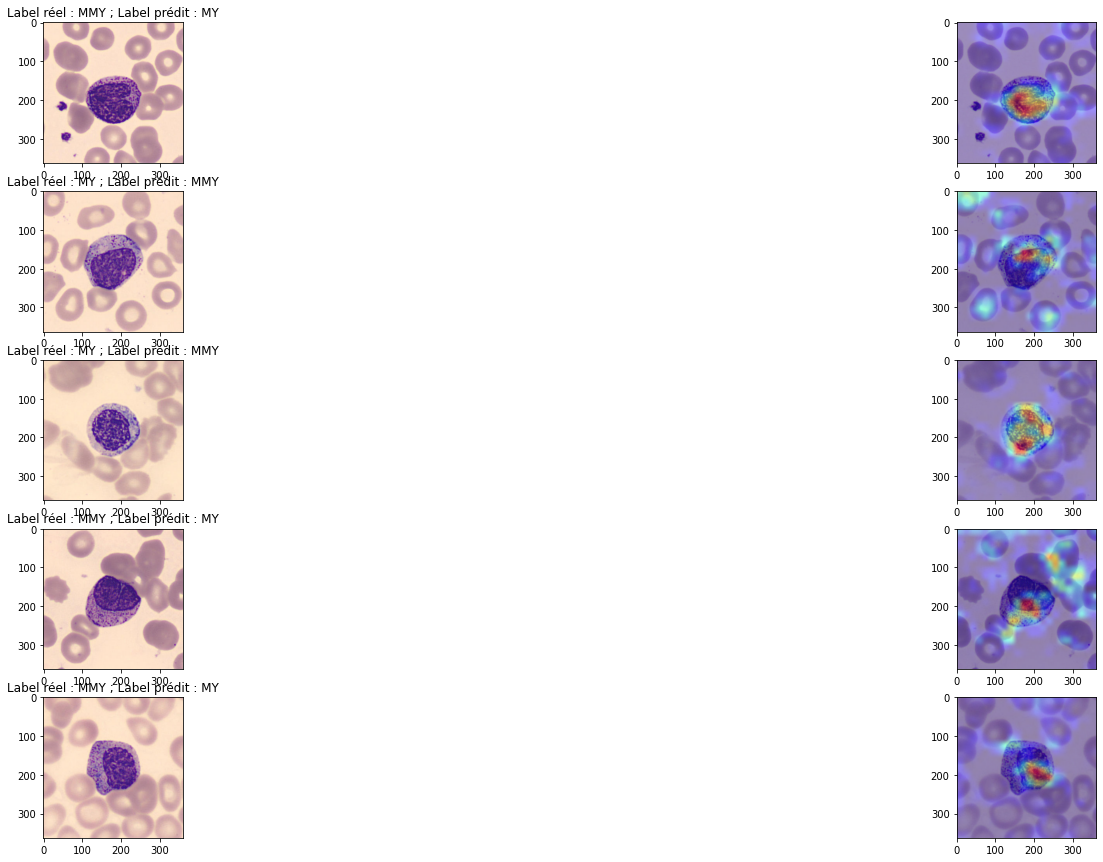

In [18]:
# Exemple : Confusion MY/MMY : labels 5 et 7
conf_my_mmy = df_false[((df_false["real"] == 5) & (df_false["pred"] == 7)) | ((df_false["real"] == 7) & (df_false["pred"] == 5))]

fig = plt.figure(figsize = (30,15))
i = 0

for id in np.random.choice(conf_my_mmy.index, size = 5, replace = False):

  img_path = conf_my_mmy.loc[id,"img_path"]
  big_heatmap, superimposed_img = gradcam(model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(5,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf_my_mmy.loc[id,"real"]],
                                                   list(label_map.keys())[conf_my_mmy.loc[id,"pred"]]))
  
  fig.add_subplot(5,2,i+2)
  plt.imshow(superimposed_img)
  i += 2

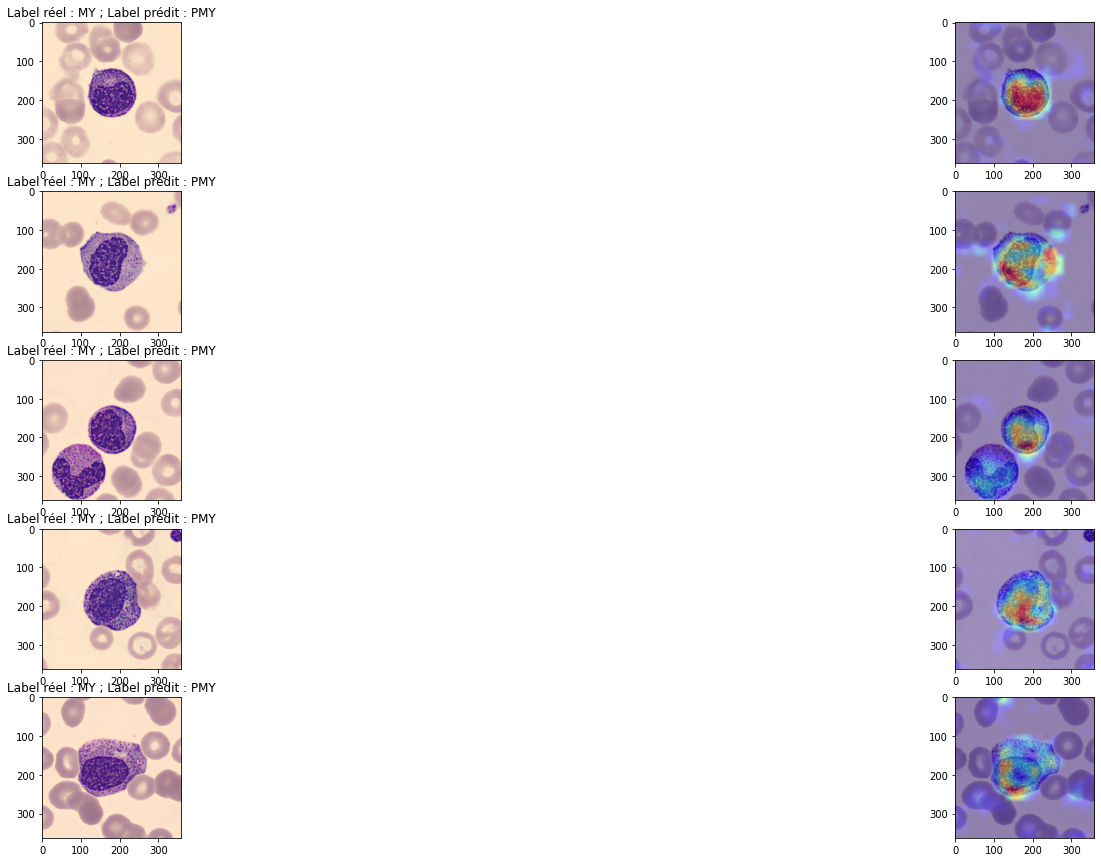

In [19]:
# Exemple : Confusion PMY/MY : labels 9 et 7
conf_pmy_my = df_false[((df_false["real"] == 9) & (df_false["pred"] == 7)) | ((df_false["real"] == 7) & (df_false["pred"] == 9))]

fig = plt.figure(figsize = (30,15))
i = 0

for id in np.random.choice(conf_pmy_my.index, size = 5, replace = False):

  img_path = conf_pmy_my.loc[id,"img_path"]
  big_heatmap, superimposed_img = gradcam(model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(5,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf_pmy_my.loc[id,"real"]],
                                                   list(label_map.keys())[conf_pmy_my.loc[id,"pred"]]))
  
  fig.add_subplot(5,2,i+2)
  plt.imshow(superimposed_img)
  i += 2

In [ ]:
######################################################################### 05/08/21 - FINE TUNING #######################################################################################

In [13]:
# Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 3, verbose = 1, mode = 'min', min_lr = 1e-7)
  
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 4, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]
                    
## Compute weights :
class_weights = compute_weights(method = 3)

## Unfreeze Block5 + Compile   (Rq: on pourrait essayer de dégeler block4 + block5)

for layer in model.layers:
  if "block5" in layer.name:
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer = optimizer,
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

## Training :
epochs = 20
history = model.fit(x = training_set, 
                    epochs = epochs,
                    callbacks = callbacks_list, 
                    validation_data = validation_set, 
                    class_weight = class_weights)
## remplacer history par fine_history pour éviter d'écraser history...

### Entraînement sans "base_model.training = False" dans VGG (03/08/21): Accuracy : 8.7%, Val Acc : 6.82%, Test Acc : 8.29% => Catastrophe...
# Pas compris pourquoi...

Epoch 1/20
397/397 [==============================] - 367s 920ms/step - loss: 4.0307 - accuracy: 0.7884 - val_loss: 0.4722 - val_accuracy: 0.8364
Epoch 2/20
397/397 [==============================] - 365s 919ms/step - loss: 2.3102 - accuracy: 0.8710 - val_loss: 0.3458 - val_accuracy: 0.8844
Epoch 3/20
397/397 [==============================] - 366s 923ms/step - loss: 1.8691 - accuracy: 0.8939 - val_loss: 0.3890 - val_accuracy: 0.8613
Epoch 4/20
397/397 [==============================] - 363s 915ms/step - loss: 1.8416 - accuracy: 0.8982 - val_loss: 0.3294 - val_accuracy: 0.8890
Epoch 5/20
397/397 [==============================] - 365s 919ms/step - loss: 1.6055 - accuracy: 0.9089 - val_loss: 0.2349 - val_accuracy: 0.9145
Epoch 6/20
397/397 [==============================] - 364s 916ms/step - loss: 1.5447 - accuracy: 0.9117 - val_loss: 0.2952 - val_accuracy: 0.8913
Epoch 7/20
397/397 [==============================] - 362s 912ms/step - loss: 1.4784 - accuracy: 0.9152 - val_loss: 0.3351 -

In [14]:
model.evaluate(testing_set)
# Overfitting léger.

80/80 [==============================] - 15s 187ms/step - loss: 0.2030 - accuracy: 0.9214


[0.202951580286026, 0.9213836193084717]

In [16]:
## Sauvegarde :
model.save("/content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_trainfalse")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/VGG19_TL_11/model_fullsave_trainfalse/assets


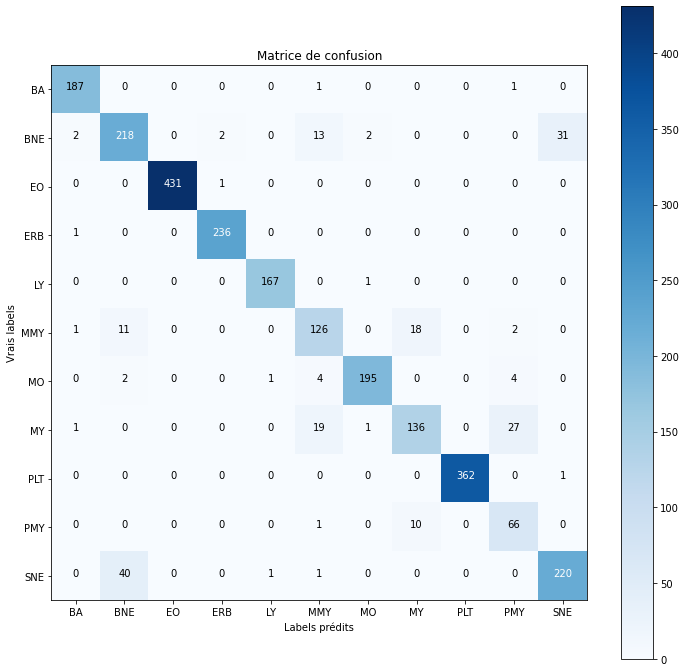

Classification Report : 


precision    recall  f1-score support
BA   0.973958  0.989418  0.981627     189
BNE  0.804428  0.813433  0.808905     268
EO          1  0.997685  0.998841     432
ERB  0.987448  0.995781  0.991597     237
LY   0.988166  0.994048  0.991098     168
MMY  0.763636  0.797468  0.780186     158
MO   0.979899  0.946602  0.962963     206
MY   0.829268   0.73913  0.781609     184
PLT         1  0.997245  0.998621     363
PMY      0.66  0.857143  0.745763      77
SNE  0.873016  0.839695  0.856031     262

In [15]:
def print_classification_report(testing_set, labels):

  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred)
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report : après fine-tuning")
  return display(df_report)

print_classification_report(testing_set, label_map)

# df_report => csv => Drive

In [ ]:
"""
Le tuning de VGG a amélioré le F1 de toutes les classes sans exception. Toujours des problèmes avec MY/MMY/PMY et BNE/SNE.
Pistes : 
1°/ fine-tuning du 'block4' en plus du 'block5' 
ou
2°/ Procéder en deux temps : d'abord dégeler le block5 et entraîner, puis dégeler le block4 et entraîner.
Rq : je ne remonterais pas plus haut que le block4, sinon on risque de trop spécialiser le modèle sur les jolies images de l'hôpital de Barcelone
Rq2 : très peu d'augmentation de données dans ce run du modèle... on pourrait introduire de légères variations sur : luminosité / netteté / zoom
"""

In [17]:
### 2 -- DataFrames pour l'exploitation
predictions = model.predict(testing_set)
y_pred = tf.argmax(predictions, axis = 1)

# DF avec le résultat et le label de toutes les images du test :
df_results = pd.DataFrame(data = {"real":testing_set.classes,
                                  "pred":y_pred, 
                                  "img_path":df_test["img_path"]})

# Tri des images : mal classé (df_false), bien classé (df_true):
df_false = df_results[df_results["real"] != df_results["pred"]].reset_index(drop = True)
df_true = df_results[df_results["real"] == df_results["pred"]].reset_index(drop = True)

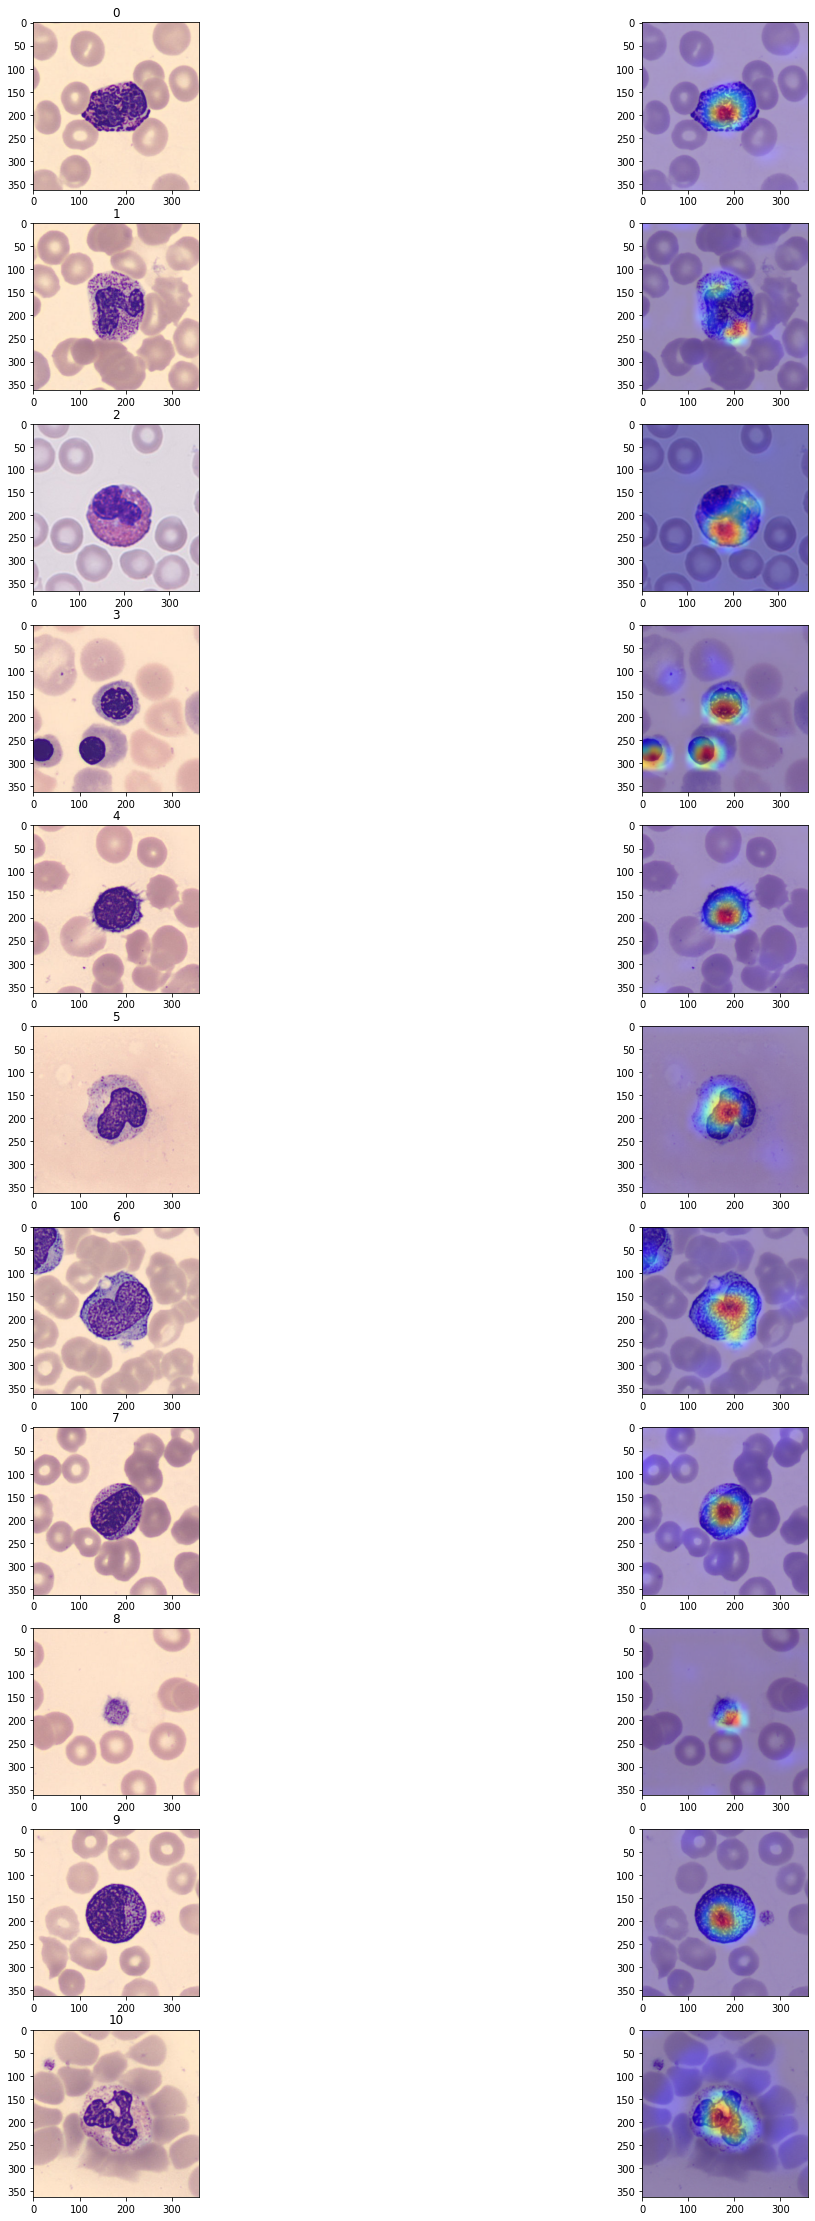

In [20]:
fig = plt.figure(figsize = (20, 40))
i = 0

for cell_class in range(n_classes):
  df_temp = df_true[df_true["real"] == cell_class]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_true.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(n_classes,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(df_true.loc[id[0],"real"])

  fig.add_subplot(n_classes,2,i+2)
  plt.imshow(superimposed_img)

  i += 2

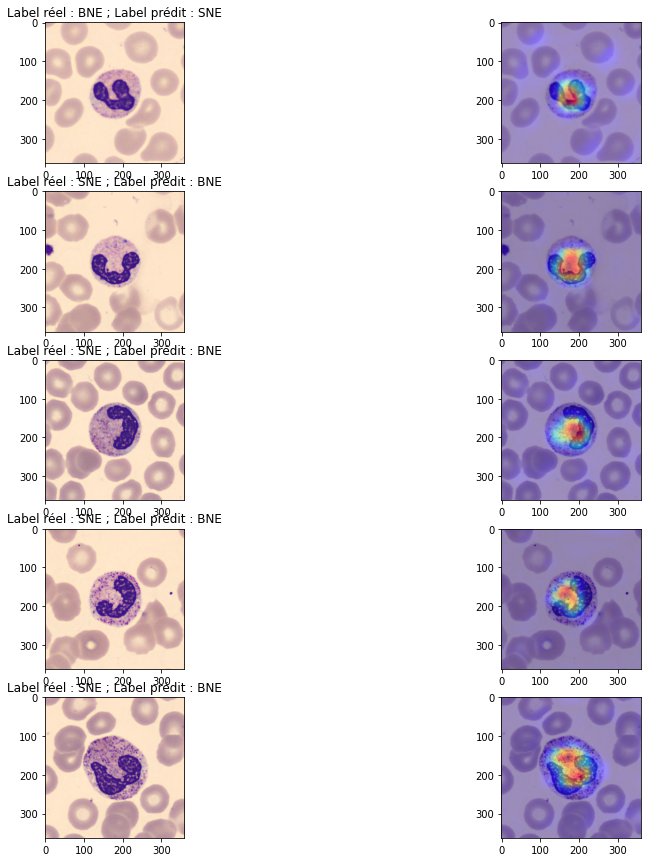

In [21]:
### 4 -- Exemples d'images mal classées :
# Exemple : Confusion BNE/SNE : labels 1 et 10

conf_bne_sne = df_false[((df_false["real"] == 1) & (df_false["pred"] == 10)) | ((df_false["real"] == 10) & (df_false["pred"] == 1))]

i = 0

fig = plt.figure(figsize = (15,15))

for id in np.random.choice(conf_bne_sne.index, size = 5, replace = False):
  img_path = conf_bne_sne.loc[id,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(5,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf_bne_sne.loc[id,"real"]],
                                                   list(label_map.keys())[conf_bne_sne.loc[id,"pred"]]))
  
  fig.add_subplot(5,2,i+2)
  plt.imshow(superimposed_img)
  i = i + 2

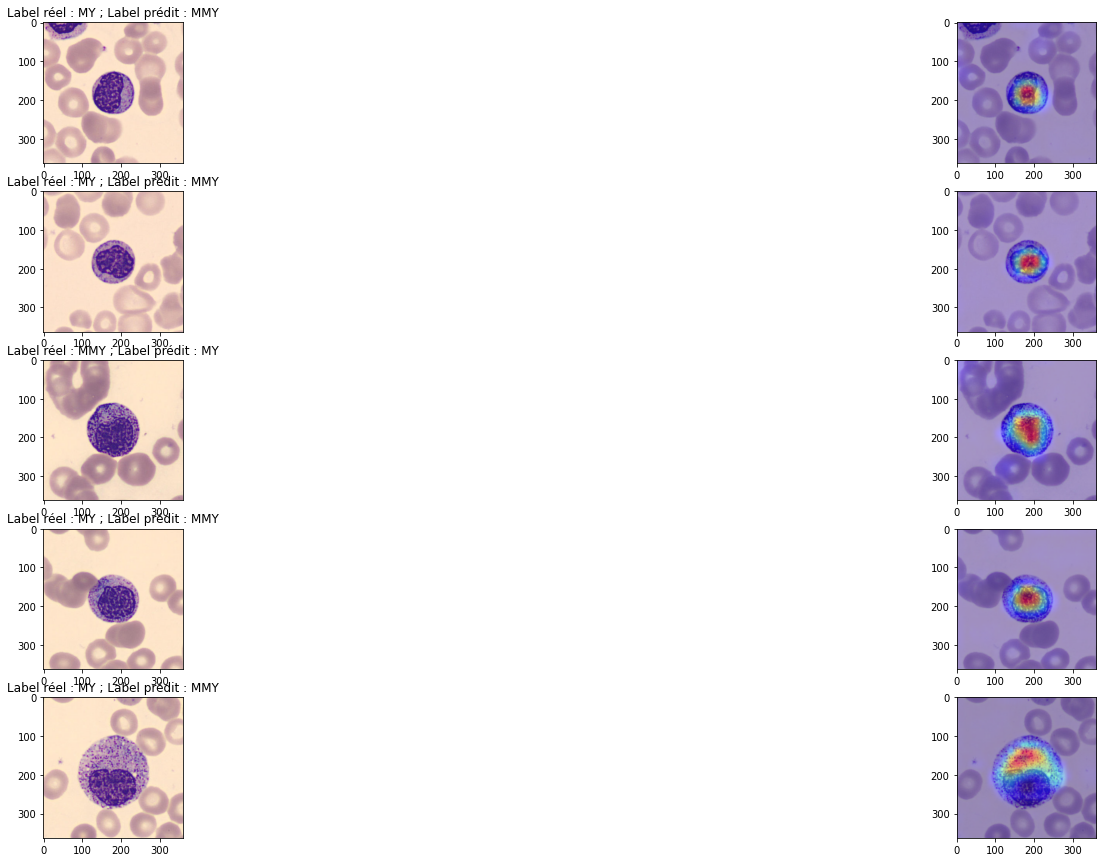

In [22]:
# Exemple : Confusion MY/MMY : labels 5 et 7
conf_my_mmy = df_false[((df_false["real"] == 5) & (df_false["pred"] == 7)) | ((df_false["real"] == 7) & (df_false["pred"] == 5))]

fig = plt.figure(figsize = (30,15))
i = 0

for id in np.random.choice(conf_my_mmy.index, size = 5, replace = False):

  img_path = conf_my_mmy.loc[id,"img_path"]
  big_heatmap, superimposed_img = gradcam(model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(5,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf_my_mmy.loc[id,"real"]],
                                                   list(label_map.keys())[conf_my_mmy.loc[id,"pred"]]))
  
  fig.add_subplot(5,2,i+2)
  plt.imshow(superimposed_img)
  i += 2

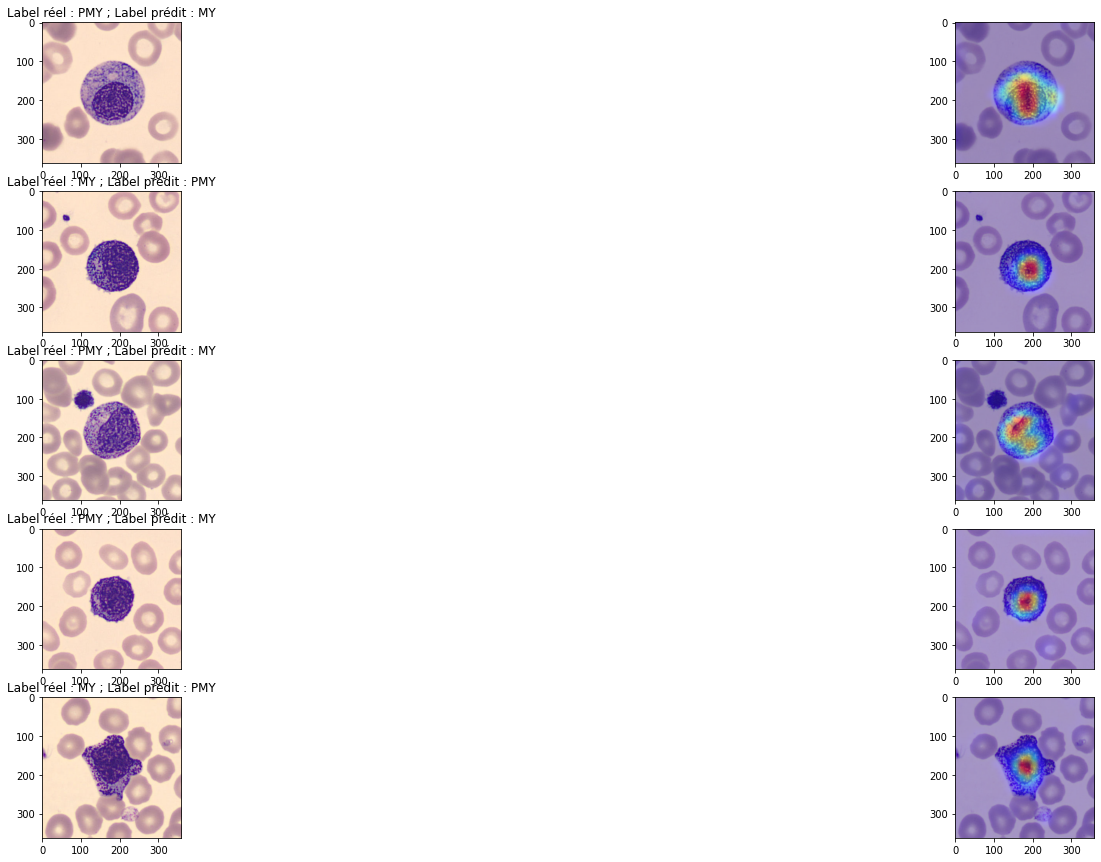

In [23]:
# Exemple : Confusion PMY/MY : labels 9 et 7
conf_pmy_my = df_false[((df_false["real"] == 9) & (df_false["pred"] == 7)) | ((df_false["real"] == 7) & (df_false["pred"] == 9))]

fig = plt.figure(figsize = (30,15))
i = 0

for id in np.random.choice(conf_pmy_my.index, size = 5, replace = False):

  img_path = conf_pmy_my.loc[id,"img_path"]
  big_heatmap, superimposed_img = gradcam(model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(5,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title("Label réel : %s ; Label prédit : %s"%(list(label_map.keys())[conf_pmy_my.loc[id,"real"]],
                                                   list(label_map.keys())[conf_pmy_my.loc[id,"pred"]]))
  
  fig.add_subplot(5,2,i+2)
  plt.imshow(superimposed_img)
  i += 2

In [ ]:
"""
On a encore du travail pour ce qui relève de l'interprétabilité du modèle. Grad-CAM montre que le modèle se concentre sur le centre de l'image,
ce qui est positif, mais il ne prend pas en compte la totalité de la cellule, seulement une partie (et qui n'est pas nécessairement le noyau)
Pistes :
- entraîner le modèle sur les images découpées "C_NMC_2019 Dataset" et comparer les Grad-CAM / performances

- tenter un clustering / une PCA en sortie de modèle, puis colorer les images mal classées sur la figure produite par le clustering / la PCA
"""

In [ ]:
""" 
Autre : 
- on pourrait intégrer les fonctions Grad-CAM à leuko_lib ... ou faire un module à part.